In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import tabulate

from IPython.display import HTML, display
from numpy.linalg import pinv
from scipy.optimize import lsq_linear

## Load data
(Source: https://www.reddit.com/r/joinsquad/comments/bp7msu/rocket_techie_range_card/)  
Thanks to u/AbsentWizard and u/Kumbulah!

In [2]:
targets_low = [100,
               200,
               300,
               400,
               500,
               750,
               1000,
               1250]
targets_high = [1492,
               1640,
               1748,
               1860,
               1950,
               2040,
               2100,
               2170,
               2183,
               2193,
               2190,
               2163]

targets_low = np.array(targets_low)
targets_high = np.array(targets_high)
targets_all = np.concatenate((targets_low, targets_high))

data_low = [0.5,
           1.5,
           2.5,
           3,
           4,
           8,
           12,
           16]

data_high = [20,
            22.5,
            25,
            27.5,
            30,
            32.5,
            35,
            40,
            42.5,
            45,
            47.3,
            49.6]

data_low = np.array(data_low)
data_high = np.array(data_high)
data_all = np.concatenate((data_low, data_high))

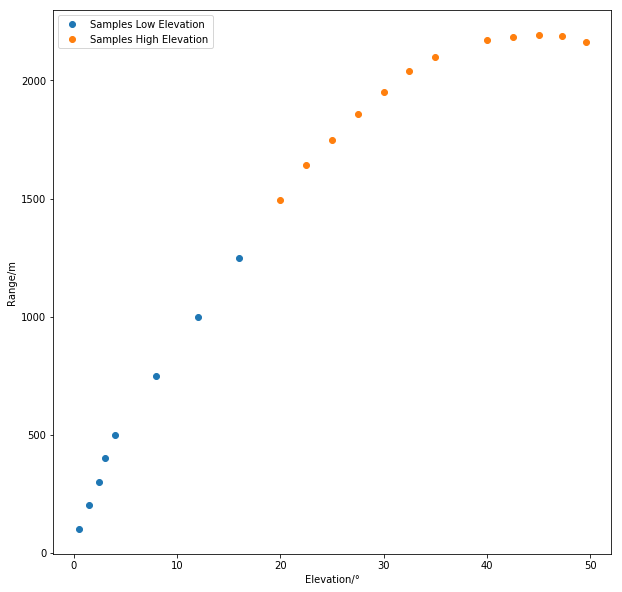

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(data_low, targets_low, linestyle='None', marker='o')
plt.plot(data_high, targets_high, linestyle='None', marker='o')
plt.xlabel('Elevation/°')
plt.ylabel('Range/m')
plt.legend(('Samples Low Elevation', 'Samples High Elevation'))

## Linear regression using cos(x) * sin(x) as basis function

Thanks to u/gebfree!

In [4]:
def cos_sin(x):
    return np.cos(x) * np.sin(x)

In [5]:
def cos_sin_linear_regression(data, targets):
    feature_vector = cos_sin(data / 180.0 * np.pi)
    feature_matrix = np.array([feature_vector, np.ones(len(feature_vector))])
    pseudo_inverse = pinv(feature_matrix.T)

    return np.matmul(pseudo_inverse, targets)

In [6]:
weight_low, offset_low = cos_sin_linear_regression(data_low, targets_low)
weight_high, offset_high = cos_sin_linear_regression(data_high, targets_high)
weight_all, offset_all = cos_sin_linear_regression(data_all, targets_all)

In [7]:
grid = np.linspace(0, 90, 10001)

Text(0, 0.5, 'Range/m')

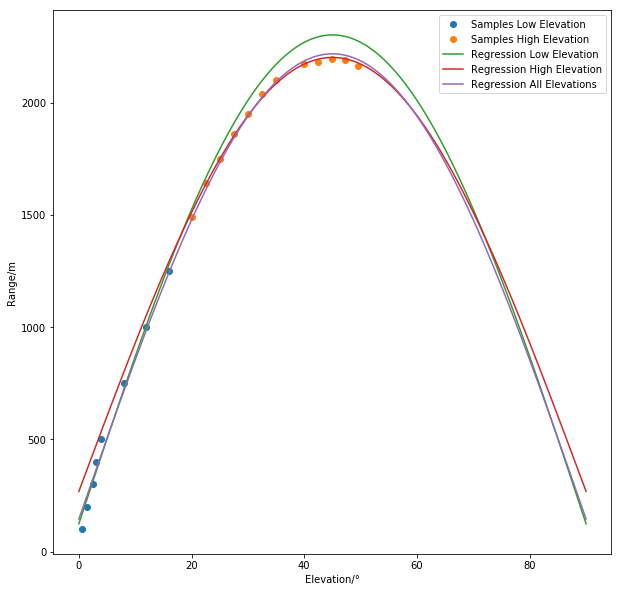

In [8]:
plt.plot(data_low, targets_low, linestyle='None', marker='o')
plt.plot(data_high, targets_high, linestyle='None', marker='o')
plt.plot(grid, weight_low * cos_sin(grid / 180.0 * np.pi) + offset_low)
plt.plot(grid, weight_high * cos_sin(grid  / 180.0 * np.pi) + offset_high)
plt.plot(grid, weight_all * cos_sin(grid  / 180.0 * np.pi) + offset_all)


plt.legend(('Samples Low Elevation',
            'Samples High Elevation',
            'Regression Low Elevation',
            'Regression High Elevation',
            'Regression All Elevations'
            ))


plt.xlabel('Elevation/°')
plt.ylabel('Range/m')

## Spline Interpolation

In [9]:
spline_low = interpolate.splrep(data_low, targets_low)
spline_high = interpolate.splrep(data_high, targets_high)
spline_all = interpolate.splrep(data_all, targets_all)

Text(40, -5000, 'Splines obviously useless\n outside sample range')

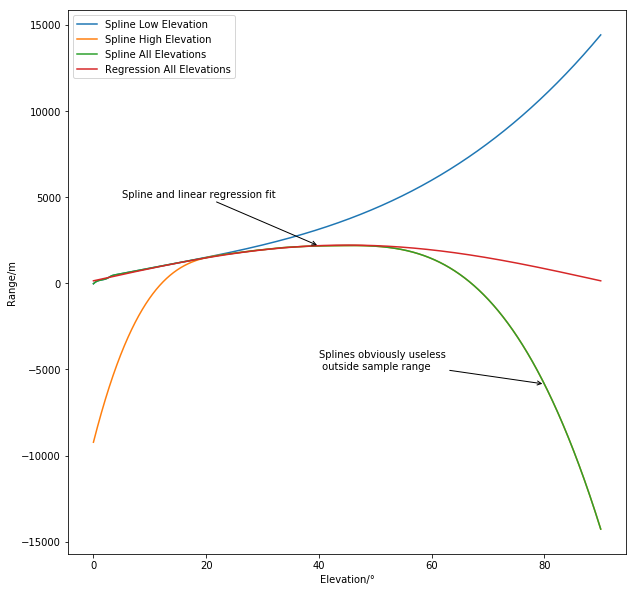

In [10]:
plt.plot(grid, interpolate.splev(grid, spline_low))
plt.plot(grid, interpolate.splev(grid, spline_high))
plt.plot(grid, interpolate.splev(grid, spline_all))
plt.plot(grid, weight_all * cos_sin(grid  / 180.0 * np.pi) + offset_all)

plt.legend(('Spline Low Elevation',
            'Spline High Elevation',
            'Spline All Elevations',
            'Regression All Elevations'
            ))


plt.xlabel('Elevation/°')
plt.ylabel('Range/m')

annotation_coords_good = (40, interpolate.splev(40, spline_all))
annotation_coords_bad= (80, interpolate.splev(80, spline_all))
plt.annotate('Spline and linear regression fit',
            annotation_coords_good,
            xytext=(5, 5000),
            arrowprops=dict(arrowstyle='->')
            )

plt.annotate('Splines obviously useless\n outside sample range',
            annotation_coords_bad,
            xytext=(40, -5000),
            arrowprops=dict(arrowstyle='->')
            )


## Range Tables Based on Linear Regression

### Table Elevation -> Range

In [11]:
table_elevations = np.arange(0, 60.5, 0.5)
table_ranges = weight_all * cos_sin(table_elevations  / 180.0 * np.pi) + offset_all

table_ranges_inverse = np.arange(145, np.floor(weight_all / 2.0 + offset_all), 25)
table_elevations_inverse = np.arcsin((table_ranges_inverse - offset_all) * 2 / weight_all) / 2 / np.pi * 180

table = [(elevation, missile_range) for elevation, missile_range in zip(table_elevations, table_ranges)]
display(HTML(tabulate.tabulate(table,
                               tablefmt='html',
                               headers=('Elevation / °', 'Range / m'))))

Elevation / °,Range / m
0,144.333
0.5,180.512
1,216.68
1.5,252.825
2,288.938
2.5,325.007
3,361.02
3.5,396.968
4,432.839
4.5,468.621


### Table Range -> Elevation

In [12]:
table = [(missile_range, elevation) for missile_range, elevation in zip(table_ranges_inverse, table_elevations_inverse)]
display(HTML(tabulate.tabulate(table,
                               tablefmt='html',
                               headers=('Range / m', 'Elevation / °'))))

Range / m,Elevation / °
145,0.00921579
170,0.354714
195,0.700263
220,1.04591
245,1.39172
270,1.73772
295,2.08399
320,2.43055
345,2.77747
370,3.12481
